CHANGE ALL COMMENTS THROUGHOUT CODE TO YOUR OWN WORDS (not the markdown though)

Check out the notes in 'access_mnist_fashionmnist.ipynb' to write up description for this part.

The following section takes you up to and including step 5 in project.

In [182]:
import os
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms


Checking to see if GPU support is available (ended up being unavailable and had to continue the project using CPU).

In [183]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU support is available.")
else:
    print("GPU support is not available. Using CPU.")

GPU support is not available. Using CPU.


In [184]:
# Define the directory where you want to save the dataset
download_path = r'C:\\Users\\mirar\\OneDrive\\Desktop\\WINTER_TERM\\Mining_Modeling\\P2\\MNIST'

# Check if the directory exists, if not create it
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Define the transformation
transform = transforms.ToTensor()

# Set the batch size
batch_size = 8

# Create the training dataset object
trainset = torchvision.datasets.MNIST(root=download_path, train=True, download=True, transform=transform)

# Create the test dataset object
testset = torchvision.datasets.MNIST(root=download_path, train=False, download=True, transform=transform)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [185]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 5)

Plotting example image to ensure data has been loaded correctly

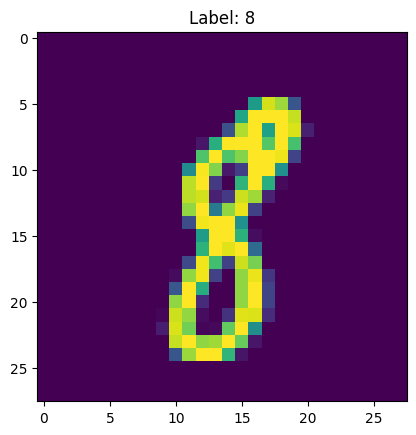

In [186]:
index = 300  # This selects the image from the training data by index number

image, label = trainset[index] # Get the image and its label

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.show()

Determining length of training and testing subsets, then subsetting the training data into training and validation datasets using a proportional split of 80% for training, and 20% for validation.

In [187]:
len(trainset), len(testset)

(60000, 10000)

In [188]:
trainset, valset = torch.utils.data.random_split(trainset, [0.80, 0.20])
len(trainset), len(valset), len(testset)

(48000, 12000, 10000)

In [189]:
print(f'Number of batches in the training set: {int(38400 / batch_size)}')
print(f'Number of batches in the validation set: {int(9600 / batch_size)}')

Number of batches in the training set: 4800
Number of batches in the validation set: 1200


Defining CNN architecture, ensuring formatting for greyscale (MNIST) imagery.

In [190]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened features after all convolutional and pooling layers
        self._flattened_features = self._get_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self._flattened_features, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop2 = nn.Dropout(p=0.3)
        self.out = nn.Linear(in_features=512, out_features=10)

    def _get_conv_output_size(self):
        # Create a dummy input to pass through the convolutional layers only
        dummy_input = torch.zeros([1, 1, 28, 28])  # Use the provided input dimensions
        dummy_input = self.conv1(dummy_input)
        dummy_input = self.pool1(dummy_input)
        dummy_input = self.conv2(dummy_input)
        dummy_input = self.pool2(dummy_input)
        dummy_input = self.conv3(dummy_input)
        dummy_input = self.pool3(dummy_input)
        return int(torch.flatten(dummy_input, 1).size(1))

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        # Output layer
        x = self.out(x)

        return x

Selecting loss function and optimization technique.

See chatgpt answer for why these are suitable and why you didn't want to play around with them: "
For the MNIST dataset and grayscale imagery, the choices of loss function and optimization technique you've selected are quite suitable and commonly used:

Loss Function:

nn.CrossEntropyLoss(): This is a good choice for multi-class classification tasks like the MNIST dataset. It combines the softmax activation function and the negative log-likelihood loss. It's particularly useful when dealing with classification problems where each sample can only belong to one class, which is the case for MNIST digits.
Optimization Technique:

optim.Adam(net.parameters(), lr=0.0001): Adam is a popular optimization algorithm that adapts the learning rate for each parameter. It's generally effective for a wide range of deep learning tasks and is often a good choice as a default optimizer. The learning rate you've chosen (0.0001) is commonly used for training neural networks and should work well for MNIST.
Given the characteristics of the MNIST dataset and the task of classifying grayscale images of handwritten digits into their respective classes, the choices you've made are appropriate and should yield good results. It's always a good idea to start with these commonly used choices and then experiment with different options as needed, based on the specific characteristics of your model and dataset."

DELETE THAT AFTERWARDS!!!!!!!!!!!!!!!!!!!!^^^^^^^^^^^

In [191]:
net = NeuralNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Defining and running the training loop, then running training with a single epoch as a first run.

In [195]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, (inputs, labels) in enumerate(trainset):

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [batch_size, 5]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  # print every 10 batches
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print("Input shape:", inputs.shape)
  print("Input head:", inputs[:5])  # Print the first 5 elements
  print("Output shape:", outputs.shape)
  print("Output head:", outputs[:5])  # Print the first 5 elements

In [193]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, (inputs, labels) in enumerate(valset):
        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 5]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valset)
    avg_acc_across_batches = (running_accuracy / len(valset)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

Training the model

In [194]:
num_epochs = 1

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training')

Epoch: 1



RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x9 and 2304x1024)